# Cokriging from maximum likelihood estimates over continental US

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import fields
import cov_model
import cokrige
import krige_tools

In [4]:
# Analysis variables
timestamp = "2019-08-01"
timedelta = -1

# Variogram settings
bin_centers = np.linspace(0, 4.5e3, 20)
tol = 250

# Initial guess for covariance params
cov_guess = [0.4, 1e3, 0.1]
cross_guess = [1e3, -0.1]

In [5]:
# Get data: 5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly_conus.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var"]]

mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, full_detrend=True, standardize_window=True, fast_dist=True)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


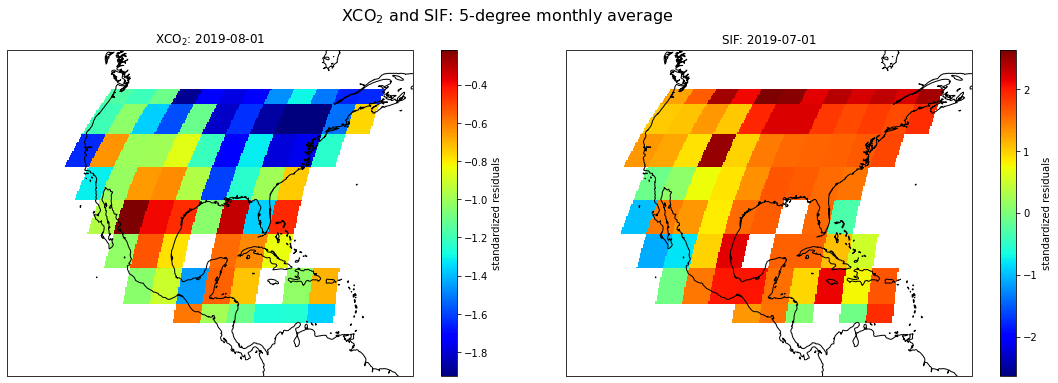

In [6]:
# Plot the data being used for cokriging
# NOTE: figures should share a color bar, but we just want a quick look
fig = plt.figure(figsize=(20, 6))
gs = fig.add_gridspec(100, 100)
extents = [-125, -60, 5, 50]

fig.suptitle(
    "XCO$_2$ and SIF: 5-degree monthly average", 
    size=16, y=0.98
)

# Input data
ax1 = fig.add_subplot(gs[:, 0:50], projection=ccrs.EqualEarth())
ax2 = fig.add_subplot(gs[:, 50:], projection=ccrs.EqualEarth())

xr.plot.imshow(
        darray=mf.field_1.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax1,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax1.coastlines()
ax1.set_extent(extents)
ax1.set_title(f"XCO$_2$: {mf.field_1.timestamp}")

xr.plot.imshow(
        darray=mf.field_2.to_xarray()["values"].T,
        transform=ccrs.PlateCarree(),
        ax=ax2,
        cmap="jet",
        cbar_kwargs={"label": "standardized residuals"},
    )
ax2.coastlines()
ax2.set_extent(extents)
ax2.set_title(f"SIF: {mf.field_2.timestamp}");

In [30]:
k1 = cov_model.Matern()
k2 = cov_model.Matern()
model = cov_model.BivariateMatern(mf, k1, k2).fit_empirical_kernels(bin_centers, tol, cov_guess, cross_guess)
# predictor = cokrige.Cokrige(mf, model, fast_dist=True)

In [31]:
# TODO: try other bounded optimization algorithms
guess = list(model.get_params().values())
guess[3] = 2000
guess[4] = -0.5
model.fit(initial_guess=guess)

[0.6360441398459342, 1682.505026785065, 0.12497718244470675, 2000, -0.5, 0.8778502848091307, 999.5517204942358, 0.25181919781674766] [(0.001, 10.0), (1.0, 10000.0), (0.5, 10.0), (1.0, 10000.0), (-1.0, 1.0), (0.001, 10.0), (1.0, 10000.0), (0.5, 10.0)]
{'sigma_11': 0.6360441398459342, 'len_scale_11': 1682.505026785065, 'nugget_11': 0.5, 'len_scale_12': 2000.0, 'rho': -0.5, 'sigma_22': 0.8778502848091307, 'len_scale_22': 999.5517204942358, 'nugget_22': 0.5}
{'sigma_11': 0.6360441498459343, 'len_scale_11': 1682.505026785065, 'nugget_11': 0.5, 'len_scale_12': 2000.0, 'rho': -0.5, 'sigma_22': 0.8778502848091307, 'len_scale_22': 999.5517204942358, 'nugget_22': 0.5}
{'sigma_11': 0.6360441398459342, 'len_scale_11': 1682.5050267950649, 'nugget_11': 0.5, 'len_scale_12': 2000.0, 'rho': -0.5, 'sigma_22': 0.8778502848091307, 'len_scale_22': 999.5517204942358, 'nugget_22': 0.5}
{'sigma_11': 0.6360441398459342, 'len_scale_11': 1682.505026785065, 'nugget_11': 0.50000001, 'len_scale_12': 2000.0, 'rho': 

LinAlgError: 130-th leading minor of the array is not positive definite